In [1]:
# Torch, Sklearn imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## AllenNLP
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from allennlp.modules.token_embedders import BertEmbedder

print("PyTorch: {}".format(torch.__version__))
print("AllenNLP: {}".format(allennlp.__version__))

PyTorch: 1.0.0
AllenNLP: 0.8.0


In [2]:
## NLP libs
from nltk import download
import gensim
from nltk.corpus import stopwords
download('stopwords')

## General libs
import numpy as np
import pandas as pd
from string import punctuation
import os, re, sys, json, requests, pickle

02/04/2019 23:42:27 - INFO - summarizer.preprocessing.cleaner -   'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsilvei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!ls ../../vectors/

GoogleNews-vectors-negative300.bin
crawl-300d-2M.vec
elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json
elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5
glove.42B.300d.txt
glove.840B.300d.txt
lid.176.ftz
uncased_L-12_H-768_A-12
uncased_L-24_H-1024_A-16
wiki-news-300d-1M-subword.txt
wiki-news-300d-1M.txt


In [4]:
# Set data locations
bucket = 'adp-e-ml-notebooks-sagemaker'                        # replace this with your own bucket
prefix = 'vectors'   # replace this with your own prefix

elmo_weights_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'.format(prefix)
#elmo_weights_key = '{}/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5'.format(prefix)
elmo_weights_key_path = os.path.join('s3://', bucket, elmo_weights_key)
elmo_weights_key_path = '../../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
elmo_config_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'.format(prefix)
#elmo_config_key = '{}/elmo_2x1024_128_2048cnn_1xhighway_options.json'.format(prefix)
elmo_config_key_path = os.path.join('s3://', bucket, elmo_config_key)
elmo_config_key_path = '../../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'

### Elmo Instance
elmo = Elmo(elmo_config_key_path, 
            elmo_weights_key_path, 
            num_output_representations = 1, 
            dropout=0.3,
            requires_grad = False)

02/04/2019 23:42:28 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [5]:
elmo.eval()

# use batch_to_ids to convert sentences to character ids
sentences = [['First', 'sentence', '.', 'here'],
            ['First', 'sentence', '.'],
            ['First', 'sentence', 'second'],
            ['First', 'sentence', 'second'],
            ['First', 'sentence', 'right']]
character_ids = batch_to_ids(sentences)
elmo_embeddings = elmo(character_ids)
for i in range(len(sentences)):
    print("SENT {} - EMBED {}".format(sentences[i],elmo_embeddings['elmo_representations'][0][i].sum()))

SENT ['First', 'sentence', '.', 'here'] - EMBED 21.57114601135254
SENT ['First', 'sentence', '.'] - EMBED 7.291922569274902
SENT ['First', 'sentence', 'second'] - EMBED -19.64456558227539
SENT ['First', 'sentence', 'second'] - EMBED -19.64456558227539
SENT ['First', 'sentence', 'right'] - EMBED -26.144351959228516


In [6]:
elmo.get_output_dim()

1024

## Processing Dataset

In [7]:
def transformText(text, do_stop=False, do_stem=False):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()
    
    # Cleaning input
    text = text.replace("'s","")
    text = text.replace("’s","")
    text = text.replace("?","")
    text = text.replace("-","")
    text = text.replace('"',"")
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    if (do_stem==True):
        # Stemming
        text = gensim.parsing.preprocessing.stem_text(text)
    return text

def strip_punctuation(s):
    return ''.join(c for c in s if c not in PUNCT)

## Lemmatization function based on Spacy Library
def lemmatizer_spacy(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [8]:
dataset = pd.read_csv('intents.csv', sep=';')
dataset.rename(index=str, columns={"Intent": "intent", 
                                   "result": "phrases"},inplace=True)
dataset['clean_text']=dataset['phrases'].apply(lambda x: transformText(x))

## Augment dataset w/ more training phrases
dataset = pd.concat([dataset, dataset]).reset_index(drop=True)
## Suffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
## Build word vocabulary
word_to_ix = {}
for sent in dataset.clean_text:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print("Tamanho do dicionario: {}".format(len(word_to_ix)))
## Build label vocabulary
label_to_ix = {}
for label in dataset.intent:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
print("Tamanho dos labels: {}".format(len(label_to_ix)))
data_split = int(0.8*len(dataset))
train_dataset = dataset[:data_split]
test_dataset = dataset[data_split:-1].reset_index(drop=True)

Tamanho do dicionario: 766
Tamanho dos labels: 169


In [9]:
def get_elmo(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    return avg

In [10]:
def get_elmo_batch(sent):
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    #rep = rep.squeeze(dim=0)
    #avg = rep.mean(dim=0)
    #avg = x.mean(dim=0) for x in rep
    rep = rep.mean(dim=1)
    return rep

In [11]:
class Intents(Dataset):
    def __init__(self, dataframe, embed_type):
        self.len = len(dataframe)
        self.label_to_ix = {}
        self.data = dataframe
        self.embed_type = embed_type
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        if self.embed_type == 'bert':
            X = get_features(phrase, max_seq_length, out_layers, zero_pad, include_special_tokens)
        elif self.embed_type == 'w2v':        
            X = get_avg_sentence_vector(phrase)
        elif self.embed_type == 'elmo':
            X = get_elmo(phrase)
        y = label_to_ix[self.data.intent[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [12]:
training_set = Intents(train_dataset,"elmo")
testing_set = Intents(test_dataset, "elmo")

In [13]:
torch.cuda.is_available()

False

## Simple MLP Classifier

In [14]:
class MLPUncertainty(nn.Module):
    def __init__(self, inputdim, 
                        nclasses, 
                        nhidden, 
                        dropout = 0,
                        cudaEfficient=True,
                        decay = 1e-6):
        super(MLPUncertainty, self).__init__()
        """
        PARAMETERS:
        -dropout:    dropout for MLP
        """
        
        self.inputdim = inputdim
        self.hidden_dim = nhidden
        self.dropout = dropout
        self.decay = decay
        self.nclasses = nclasses
        
        if cudaEfficient:
            self.model = nn.Sequential(
                nn.Linear(self.inputdim, nhidden),
                nn.Dropout(p=self.dropout),
                nn.ReLU(),
                nn.Linear(nhidden, self.nclasses),
                ).cuda()
        else:
            self.model = nn.Sequential(
                nn.Linear(self.inputdim, nhidden),
                nn.Dropout(p=self.dropout),
                nn.ReLU(),
                nn.Linear(nhidden, self.nclasses),
                )
    def forward(self, x):
        log_probs = self.model(x)
        return log_probs

In [15]:
elmo.get_output_dim()

1024

In [16]:
INP_DIM = elmo.get_output_dim()
NUM_LABELS = len(label_to_ix)
NHIDDEN = 1024
DROPOUT = 0.2
model = MLPUncertainty(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT, 
              cudaEfficient = False)
#device = torch.device("cuda:0")
#model = model.to(device)
#model.cuda()

## Training

In [17]:
# Dataloaders Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 0}
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [18]:
max_epochs = 5
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(training_loader):
        
        ## Step 1 - Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        #sent = Variable(sent.cuda())
        #label = Variable(label.cuda())
        
        ## Step 2 - Run forward pass
        output = model.forward(sent)
        
        ## Step 3 - Compute loss
        loss = loss_function(output, label)
        loss.backward()
        
        ## Step 4 = Update parameters
        optimizer.step()
        if i%100 == 0:
            
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            for sent, label in testing_loader:
                #sent = Variable(sent.cuda())
                #sent = Variable(get_elmo_batch(sent))
                #label = Variable(label.cuda())
                
                # Forward pass only to get logits/output
                output = model.forward(sent)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(output.data, 1)
                
                # Total number of labels
                total += label.size(0)

                # Total correct predictions
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.data, accuracy))

EPOCH -- 0


KeyboardInterrupt: 

In [ ]:
def get_reply(phrase, model):
    x = get_elmo(phrase)
    #print(x)
    #print("ELMo value sum: {}".format(x.sum().cpu().data.numpy()))
    logits_out = model.forward(Variable(x))
    softmax_out = F.softmax(logits_out, dim=0)
    _, pred_label = torch.max(softmax_out.data, 0)
    prediction=list(label_to_ix.keys())[list(label_to_ix.values()).index(pred_label)]
    return prediction

In [ ]:
intent = "demote worker"
for i in range(0,10):
    print(get_reply(intent, model))

In [ ]:
model_version = 'third'
model_name = '{}_model.ckpt'.format(model_version)
dict_name = '{}_dict.pkl'.format(model_version)

In [ ]:
model_name, dict_name

In [ ]:
torch.save(model.state_dict(), model_name)

In [ ]:
def save_model_to_s3(model, model_name):
    import boto3
    s3 = boto3.client('s3')
    bucket_name = 'adp-e-ml-notebooks-sagemaker'
    prefix = 'training_data/elmo_intent/'
    torch.save(model.state_dict(), model_name)
    s3.upload_file(model_name, bucket_name, prefix + model_name)
    return "Done"

In [ ]:
def save_assets_to_s3(file, file_name):
    import boto3
    s3 = boto3.client('s3')
    bucket_name = 'adp-e-ml-notebooks-sagemaker'
    prefix = 'training_data/elmo_intent/'
    
    with open(file_name, 'wb') as f:
        pickle.dump((label_to_ix), f)
            
    s3.upload_file(file_name, bucket_name, prefix + file_name)
    return "Done"

In [ ]:
save_assets_to_s3(label_to_ix, dict_name)

In [ ]:
save_model_to_s3(model, model_name)

In [ ]:
## Test current model accuracy
with open('test_vector.pkl', 'rb') as f:
    test_sentences = pickle.load(f)

In [ ]:
test_sentences[0:5]

In [ ]:
correct = 0
total = 0
errors = []
for phrase, label in test_sentences:
    phrase_transformed = transformText(phrase)
    #print(phrase, "---", phrase_transformed)
    prediction = get_reply(phrase_transformed, model)
    total +=1
    if prediction == label:
        correct += 1
    else:
        errors.append((sent,label))
accuracy = 100.00 * correct / total

In [ ]:
accuracy

### Introduce Augmentation in the Training Set

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import normal

In [20]:
def get_phrase_dist(sent, n_points=100):
    elmo.eval()
    sent = sent.split()
    character_ids = batch_to_ids(sent)
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    mean = rep.mean()
    std = rep.std()
    normal_sampler = normal.Normal(mean, std)
    sampling = torch.zeros(n_points)
    for i in range(len(sampling)):
        samp = normal_sampler.sample()
        sampling[i]=samp
    return sampling.numpy(), mean, std

In [21]:
get_phrase_dist("what is love")[0][0:10]

array([ 0.00799594, -0.10313113,  0.16723543,  0.23949766, -0.13409089,
       -0.45124373,  0.15774632,  0.2353379 ,  0.38103703, -0.33568105],
      dtype=float32)

In [22]:
list_intents = {}
n_sample = 8 ## number of sampling phrases
available_intents = ["promote", 
                     "demote",
                     "jobOffer.create", 
                     "jobReferral.evaluate",
                     "personMaritalStatus.update",
                     "personGender.update"]

In [23]:
for name in available_intents:
    phrases = list(dataset.clean_text[dataset.intent == name][0:n_sample])
    list_intents.update({name:phrases})

In [24]:
def get_intent_mean_rep(list_intents):
    overall_rep = torch.zeros(len(list_intents))
    for i in list_intents:
        elmo.eval()
        sent = i.split()
        character_ids = batch_to_ids(sent)
        embeddings = elmo(character_ids)
        rep = embeddings['elmo_representations'][0]
        mean = rep.mean()
        std = rep.std()

In [25]:
get_intent_mean_rep(list_intents['demote'])

/Users/rsilvei/Envs/nlp_new/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


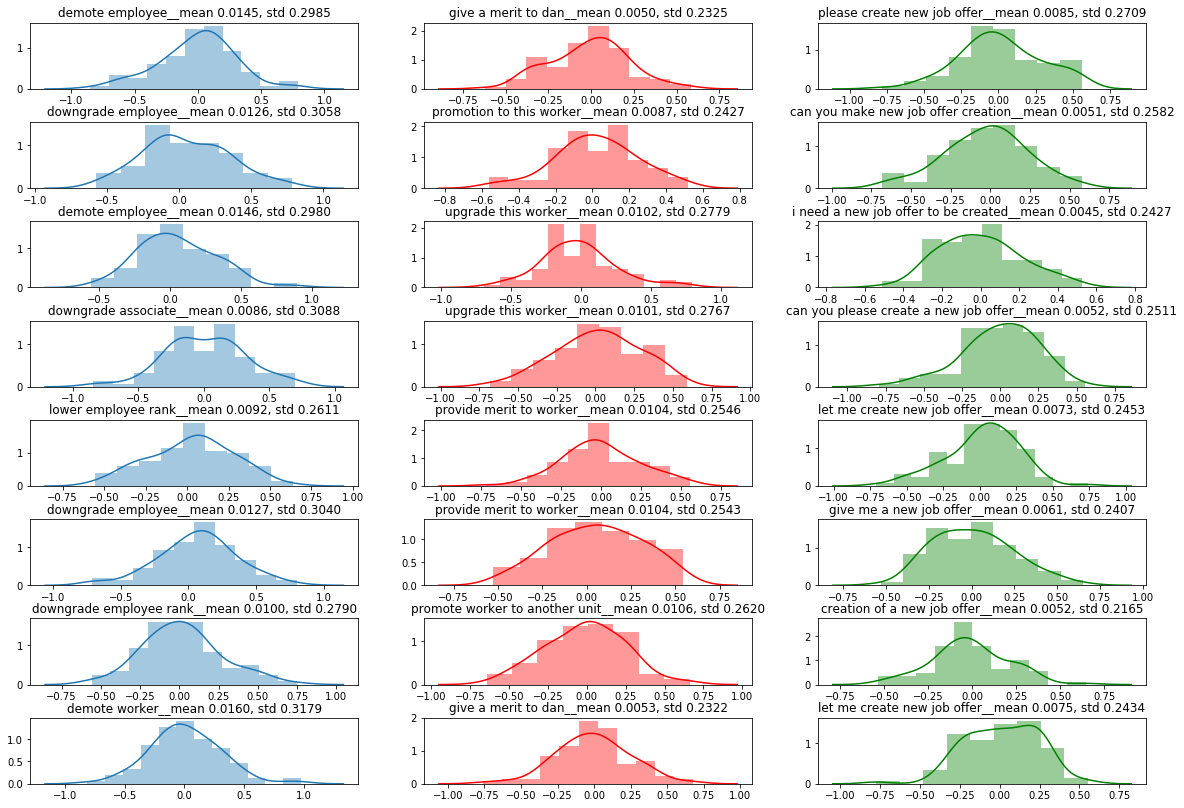

In [26]:
f, axs = plt.subplots(figsize=(20, 14),nrows=len(list_intents['demote']),ncols=3)
plt.subplots_adjust(hspace = 0.5)
for i,phrase in enumerate(list_intents['demote']):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][0]).set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))
for i,phrase in enumerate(list_intents['promote']):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][1],color="r").set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))
for i,phrase in enumerate(list_intents['jobOffer.create']):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][2],color="g").set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))

In [27]:
## Plot phrases for given dataset
n_phrase_samples = 5
list_intents = {}
available_intents = ["promote", 
                     #"demote",
                     #"jobOffer.create", 
                     #"jobReferral.evaluate",
                     "personMaritalStatus.update",
                     "personGender.update"]
for name in available_intents:
    phrases = list(dataset.clean_text[dataset.intent == name][0:n_sample])
    list_intents.update({name:phrases})

In [241]:
sentences = [[item for sublist in list(list_intents.values()) for item in sublist]]
elmo.eval()
character_ids = batch_to_ids(sentences)
embeddings = elmo(character_ids)['elmo_representations'][0].squeeze(dim=0)
embeddings_np = embeddings.detach().numpy()
embeddings_np.shape

(24, 1024)

In [242]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [243]:
tsne=TSNE(n_components=2,perplexity = 2, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
sentences_tsne.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1.020157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.847630
[t-SNE] Error after 1000 iterations: 0.278786


(24, 2)

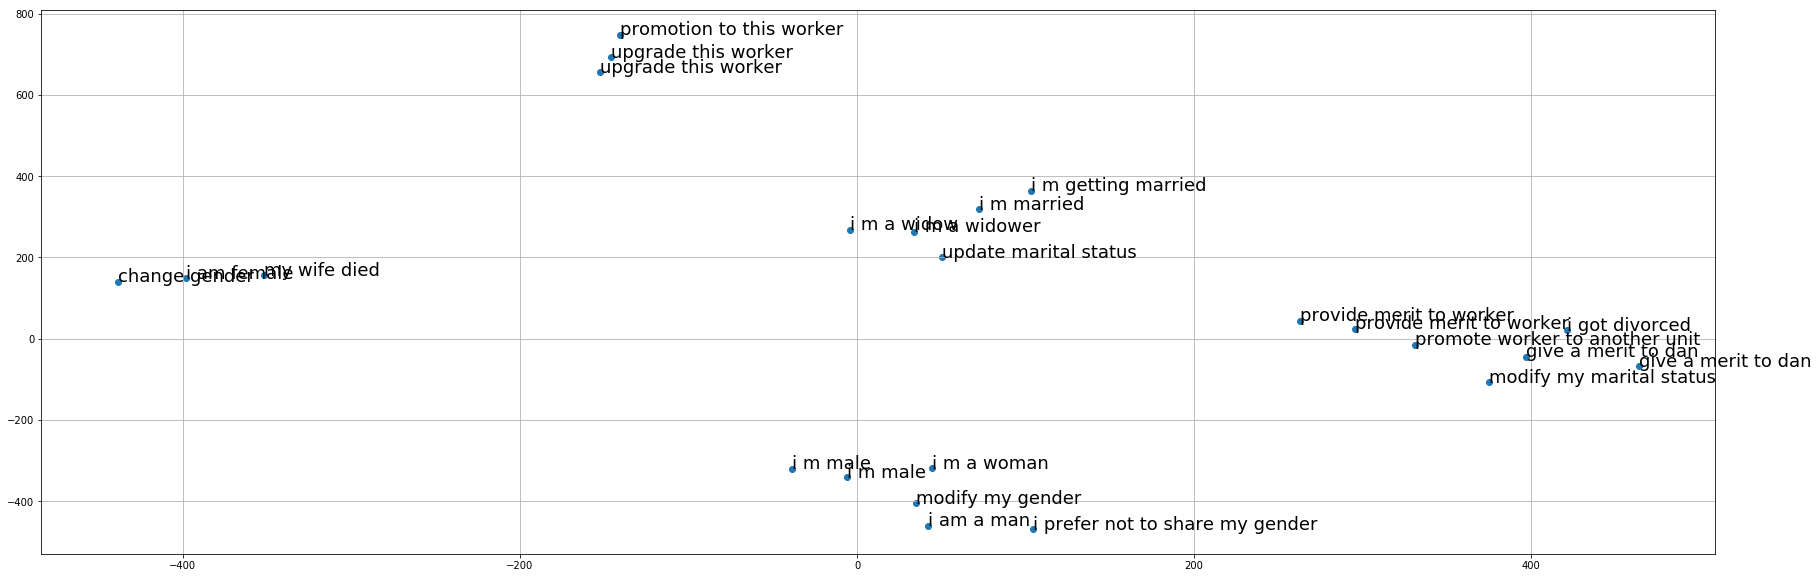

In [244]:
plt.subplots(figsize=(30, 10))
plt.grid()
plt.scatter(sentences_tsne[:,0], sentences_tsne[:,1])
for label, x, y in zip(sentences[0],sentences_tsne[:,0], sentences_tsne[:,1]):
    font = {'size' : 18, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

## Generate _mixup_ examples
Sources: 
- https://www.inference.vc/high-dimensional-gaussian-distributions-are-soap-bubble/
- https://www.inference.vc/mixup-data-dependent-data-augmentation/
- https://arxiv.org/abs/1710.09412
- https://github.com/fastai/fastai/blob/67e46d10ffd966a32e8dcf9acab78c87958c2ab6/fastai/callbacks/mixup.py

### Some hints from post
- _"So generally, when interpolating in latent spaces of something like a VAE or a GAN where you assume the distribution was Gaussian, always interpolate in polar coordinates, rather than in cartesian coordinates."_ 

In [245]:
list_intents['promote']

['give a merit to dan',
 'promotion to this worker',
 'upgrade this worker',
 'upgrade this worker',
 'provide merit to worker',
 'provide merit to worker',
 'promote worker to another unit',
 'give a merit to dan']

In [246]:
import numpy as np
import scipy
from scipy.interpolate import NearestNDInterpolator, interpn, LinearNDInterpolator

In [247]:
def get_elmo_sent(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    embeddings = elmo(character_ids)['elmo_representations'][0].squeeze(dim=0)
    embeddings = embeddings.mean(dim=0)
    embeddings_np = embeddings.detach().numpy()
    return embeddings_np

In [248]:
## INTERPOLATE TORCH
from torch.nn.functional import interpolate

In [249]:
phrases= list_intents['promote']
points = np.zeros((1024,len(phrases)))
for i,utt in enumerate(phrases):
    points[:,i] = get_elmo_sent(utt)
point = torch.tensor(points)
x = point.unsqueeze(dim=0)
x.shape

torch.Size([1, 1024, 8])

In [250]:
n_samples = 3

In [251]:
interp = interpolate(x, size=(n_samples), mode='linear').squeeze(0).numpy().T

/Users/rsilvei/Envs/nlp_new/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [252]:
interp.shape

(3, 1024)

In [253]:
embeddings_np = np.vstack((embeddings_np,interp))

In [254]:
embeddings_np.shape, len(sentences[0])

((27, 1024), 24)

In [255]:
## include label for ref
for i in range(embeddings_np.shape[0]-len(sentences[0])):
    sentences[0].append("interpolated_phrase")
sentences

[['give a merit to dan',
  'promotion to this worker',
  'upgrade this worker',
  'upgrade this worker',
  'provide merit to worker',
  'provide merit to worker',
  'promote worker to another unit',
  'give a merit to dan',
  'i m a widow',
  'i got divorced',
  'modify my marital status',
  'i m a widower',
  'i m married',
  'i m getting married',
  'update marital status',
  'my wife died',
  'i am female',
  'change gender',
  'i m male',
  'i m a woman',
  'i m male',
  'modify my gender',
  'i am a man',
  'i prefer not to share my gender',
  'interpolated_phrase',
  'interpolated_phrase',
  'interpolated_phrase']]

In [256]:
tsne=TSNE(n_components=2,perplexity = 3, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
sentences_tsne.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 1.454325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.597512
[t-SNE] Error after 1000 iterations: 0.206259


(27, 2)

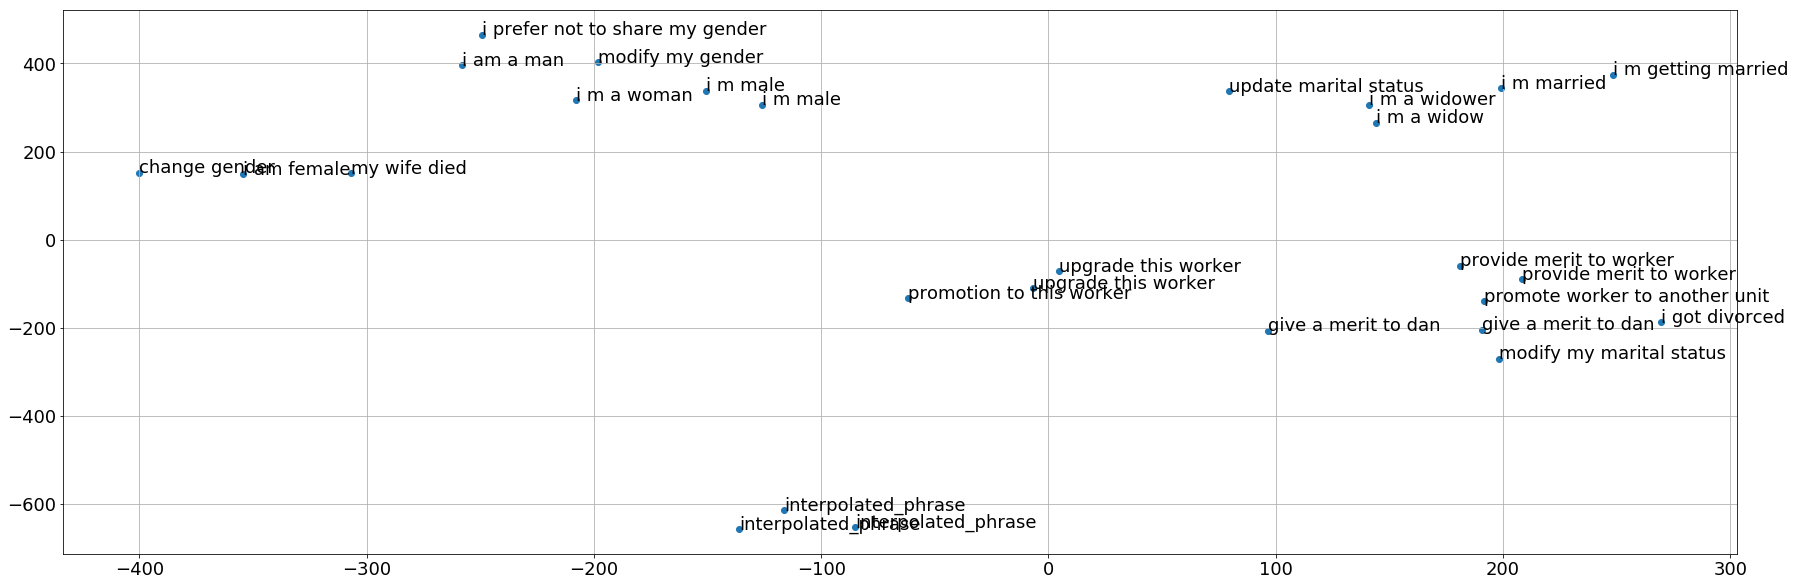

In [257]:
plt.subplots(figsize=(30, 10))
plt.grid()
plt.scatter(sentences_tsne[:,0], sentences_tsne[:,1])
for label, x, y in zip(sentences[0],sentences_tsne[:,0], sentences_tsne[:,1]):
    font = {'size' : 18, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')